# PyTorch Learning
KurwAI | Cheslaff | 🎄<br>
<img src="https://images.emojiterra.com/google/noto-emoji/unicode-16.0/color/1024px/1f9ab.png" width=5%>
<img src="https://em-content.zobj.net/source/apple/391/red-heart_2764-fe0f.png" width=5%>
<img src="https://static-00.iconduck.com/assets.00/pytorch-icon-1694x2048-jgwjy3ne.png" width=5%>

In [1]:
import torch
from torch import nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

## Data (it ain't real, but who cares)

In [2]:
m_samples = 1_000

X, y = datasets.make_circles(m_samples,
                    noise=0.04,
                    random_state=42)

X.shape, y.shape

((1000, 2), (1000,))

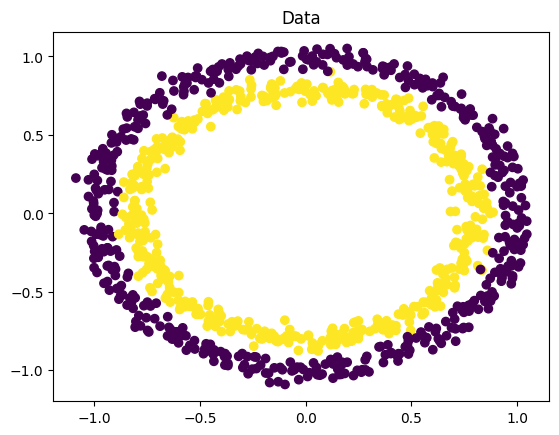

In [3]:
plt.title("Data")
plt.scatter(X[:, 0], X[:, 1], c=y);

In [4]:
val_count = np.bincount(y)
li = np.nonzero(val_count)[0]
list(zip(li, val_count[li]))  # classes are balanced

[(0, 500), (1, 500)]

In [5]:
# Convert to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [7]:
# God, bless CoLaboratory!
torch.cuda.is_available()

True

In [8]:
class SpecialModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, X):
    return self.layer_2(self.layer_1(X))

In [9]:
model = SpecialModel().to("cuda")  # since cuda is available
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.5245,  0.3277],
                      [ 0.2185,  0.5499],
                      [-0.0835, -0.5312],
                      [-0.4696, -0.0819],
                      [ 0.3769,  0.0966]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.6277, -0.3447, -0.2094,  0.3419, -0.1076], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2264, -0.1465, -0.2903, -0.3440,  0.2652]], device='cuda:0')),
             ('layer_2.bias', tensor([0.0630], device='cuda:0'))])

In [10]:
# There's another API similar to Keras
model_clone = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to("cuda")

model_clone

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
model.eval()

with torch.inference_mode():
  random_preds = model(X_test.to("cuda"))
random_preds[:10].shape, y_test[:10].shape

(torch.Size([10, 1]), torch.Size([10]))

In [12]:
# works with non-activated logits
loss_fn = nn.BCEWithLogitsLoss()  # so it's more numerically stable.
optimizer = torch.optim.Adadelta(params=model.parameters(), lr=0.1)

In [13]:
# Evaluation Metric

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()  # eq() returns where tensors are equal
  acc = (correct / len(y_true))
  return acc

In [14]:
with torch.inference_mode():
  y_pred_logits = model(X_test.to("cuda"))
  print(y_pred_logits[0])
  y_pred_probs = torch.sigmoid(y_pred_logits)
  print(y_pred_probs[0])

tensor([-0.2152], device='cuda:0')
tensor([0.4464], device='cuda:0')


## Model Training!

In [15]:
torch.manual_seed(seed=42)

epochs = 500

X_train, y_train = X_train.to("cuda"), y_train.to("cuda")
X_test, y_test = X_test.to("cuda"), y_test.to("cuda")

for epoch in range(epochs):
  model.train()

  y_logs = model(X_train).squeeze()  # remove extra dim
  y_pred = torch.round(torch.sigmoid(y_logs))

  loss = loss_fn(y_logs, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Test
  model.eval()

  with torch.inference_mode():
    test_logs = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logs))

    test_loss = loss_fn(test_logs, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.3f} | Accuracy: {acc} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.701 | Accuracy: 0.47875 | Test Loss: 0.707 | Test Accuracy: 0.495
Epoch: 50 | Loss: 0.698 | Accuracy: 0.48875 | Test Loss: 0.703 | Test Accuracy: 0.495
Epoch: 100 | Loss: 0.697 | Accuracy: 0.5 | Test Loss: 0.701 | Test Accuracy: 0.49
Epoch: 150 | Loss: 0.695 | Accuracy: 0.51 | Test Loss: 0.700 | Test Accuracy: 0.495
Epoch: 200 | Loss: 0.695 | Accuracy: 0.515 | Test Loss: 0.698 | Test Accuracy: 0.49
Epoch: 250 | Loss: 0.694 | Accuracy: 0.51375 | Test Loss: 0.697 | Test Accuracy: 0.49
Epoch: 300 | Loss: 0.694 | Accuracy: 0.51375 | Test Loss: 0.697 | Test Accuracy: 0.485
Epoch: 350 | Loss: 0.693 | Accuracy: 0.51375 | Test Loss: 0.696 | Test Accuracy: 0.48
Epoch: 400 | Loss: 0.693 | Accuracy: 0.5075 | Test Loss: 0.696 | Test Accuracy: 0.48
Epoch: 450 | Loss: 0.693 | Accuracy: 0.51375 | Test Loss: 0.695 | Test Accuracy: 0.475


<img src="https://transistor.blog/wp-content/uploads/2015/07/true-detective-9.png" width=50%><br>
**True Detective Time** <br>
1) We use PyTorch built-in layer, so they should work fine <br>
2) I also use BCEWithLogits, so it prevents gradient vanishment <br>
3) Model is really shallow. I mean, it's even no relu there <br>
4) Performance on both train and test sets is shitty <br>
5) Model Looks like random guessing. 50% of accuracy in case of balanced dataset (which I'm working with) is similar to random guessing. <br>
Maybe decision boundary is way too simple <br>

---
Conclusion: <br>
**Underfitting**

As I'm going through [PyTorch Zero To Mastery](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.learnpytorch.io/&ved=2ahUKEwjn4uvZg8qKAxWxBhAIHf8UEFQQFnoECBkQAQ&usg=AOvVaw1VDU2-SEv9r0wwUIEBuCZd) I'll use helper function

In [16]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("File already exists")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

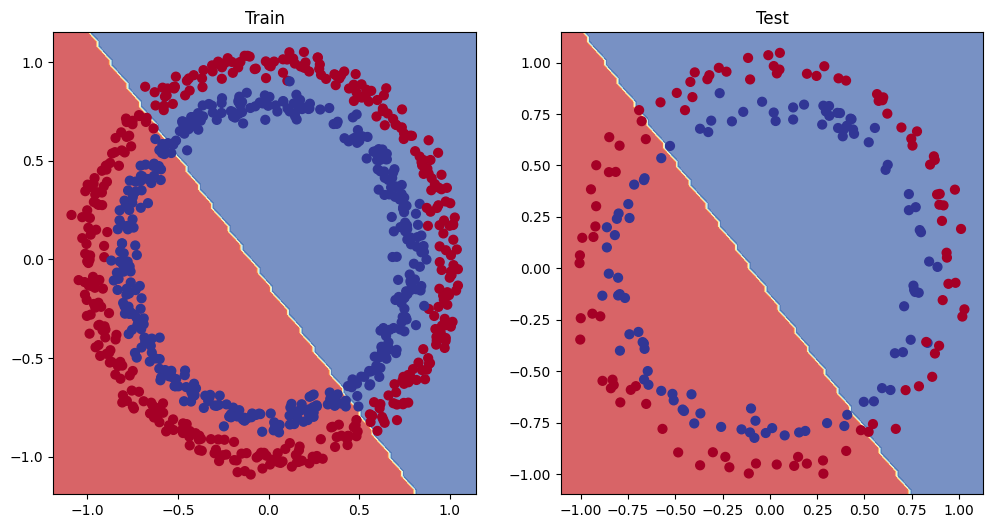

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

<p align="center"><img src="https://external-preview.redd.it/S6nXb0rboUuCx1QeVa67kWzMN6yEac2rBl6LAPN6mWg.jpg?auto=webp&s=f3862a6ac341c9e09867c5472558d5c20e5f0c64" width=35%></p><br>
<h2 align="center">That's a bingo!</h2>

In [26]:
class SpecialModel2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, X):
    out = self.layer1(X)
    out = self.relu(out)
    out = self.layer2(out)
    out = self.relu(out)
    out = self.layer3(out)
    return out


model = SpecialModel2().to("cuda")
model

SpecialModel2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [27]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [28]:
torch.manual_seed(seed=42)
epochs = 1_500

for epoch in range(epochs):
  model.train()

  pred_logs = model(X_train).squeeze()
  pred_prob = torch.round(torch.sigmoid(pred_logs))

  loss = loss_fn(pred_logs, y_train)
  acc = accuracy_fn(y_train, pred_prob)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logs = model(X_test).squeeze()
    test_prob = torch.round(torch.sigmoid(test_logs))

    test_loss = loss_fn(test_logs, y_test)
    test_acc = accuracy_fn(y_test, test_prob)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.3f} | Accuracy: {acc} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.693 | Accuracy: 0.5 | Test Loss: 0.693 | Test Accuracy: 0.5
Epoch: 100 | Loss: 0.691 | Accuracy: 0.52625 | Test Loss: 0.691 | Test Accuracy: 0.53
Epoch: 200 | Loss: 0.690 | Accuracy: 0.53375 | Test Loss: 0.690 | Test Accuracy: 0.545
Epoch: 300 | Loss: 0.688 | Accuracy: 0.53125 | Test Loss: 0.687 | Test Accuracy: 0.55
Epoch: 400 | Loss: 0.685 | Accuracy: 0.52875 | Test Loss: 0.685 | Test Accuracy: 0.555
Epoch: 500 | Loss: 0.681 | Accuracy: 0.53125 | Test Loss: 0.680 | Test Accuracy: 0.565
Epoch: 600 | Loss: 0.675 | Accuracy: 0.5425 | Test Loss: 0.674 | Test Accuracy: 0.565
Epoch: 700 | Loss: 0.667 | Accuracy: 0.585 | Test Loss: 0.665 | Test Accuracy: 0.59
Epoch: 800 | Loss: 0.652 | Accuracy: 0.64875 | Test Loss: 0.650 | Test Accuracy: 0.69
Epoch: 900 | Loss: 0.624 | Accuracy: 0.74125 | Test Loss: 0.625 | Test Accuracy: 0.78
Epoch: 1000 | Loss: 0.570 | Accuracy: 0.8625 | Test Loss: 0.580 | Test Accuracy: 0.85
Epoch: 1100 | Loss: 0.487 | Accuracy: 0.9175 | Test Loss: 0.

Holy Shit!

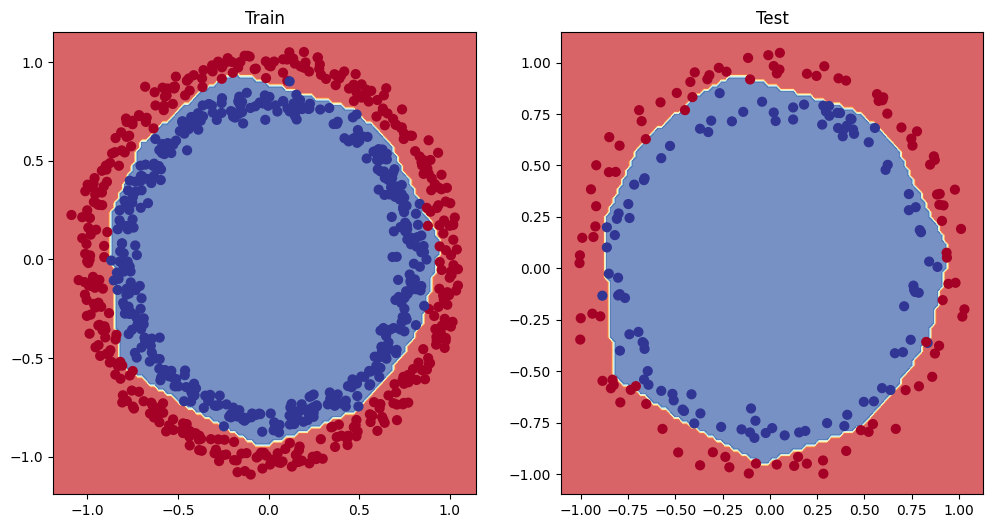

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

Maybe now it's a little bit of overfitting, but it's ok for now

## MultiClass Classification

In [62]:
# Data

N_CLASSES = 4
N_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = datasets.make_blobs(n_samples=1_000,
                                     n_features=N_FEATURES,
                                     centers=N_CLASSES,
                                     cluster_std=1.3,
                                     random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

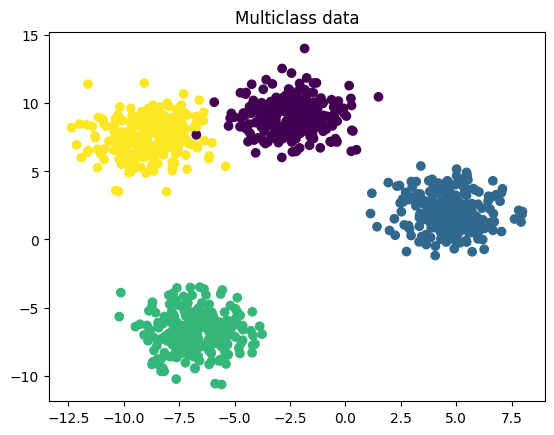

In [63]:
plt.title("Multiclass data")
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob);

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # device selection
device

'cuda'

In [75]:
class BlobGlorpModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    # We don't even need ReLU, because we can split our data with linear boundaries
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

glorpy_model = BlobGlorpModel(input_features=N_FEATURES,
                              output_features=N_CLASSES).to(device)
glorpy_model

BlobGlorpModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [76]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(glorpy_model.parameters(), lr=0.1)

In [77]:
glorpy_model.eval()

with torch.inference_mode():
  random_pred = glorpy_model(X_blob_test.to(device))
random_pred[:5]  # (m, n_classes) shape

tensor([[-1.2324, -0.7661, -1.4482, -0.5858],
        [ 1.7407, -1.2358,  1.7618,  2.1266],
        [ 2.2514,  0.7533,  2.6119,  1.0334],
        [-0.8376, -0.3857, -0.9580, -0.5591],
        [-0.3454, -1.5934, -0.5896,  0.7411]], device='cuda:0')

In [78]:
glorpy_model.eval()
with torch.inference_mode():
  logits = glorpy_model(X_blob_test.to(device))
  pred_probs = torch.softmax(logits, dim=1)  # along axis 1 (n_classes)
print(logits[0])
print(pred_probs[0])

tensor([-1.2324, -0.7661, -1.4482, -0.5858], device='cuda:0')
tensor([0.1884, 0.3003, 0.1518, 0.3596], device='cuda:0')


In [79]:
torch.manual_seed(RANDOM_SEED)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  glorpy_model.train()

  pred_logs = glorpy_model(X_blob_train)
  pred = torch.softmax(pred_logs, dim=1).argmax(dim=1)

  loss = loss_fn(pred_logs, y_blob_train)
  acc = accuracy_fn(y_blob_train, pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  glorpy_model.eval()
  with torch.inference_mode():
    test_logs = glorpy_model(X_blob_test)
    test_pred = torch.softmax(test_logs, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logs, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.3f} | Accuracy: {acc} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 1.040 | Accuracy: 0.67 | Test Loss: 0.572 | Test Accuracy: 0.965
Epoch: 10 | Loss: 0.129 | Accuracy: 0.99625 | Test Loss: 0.116 | Test Accuracy: 1.0
Epoch: 20 | Loss: 0.065 | Accuracy: 0.9975 | Test Loss: 0.059 | Test Accuracy: 1.0
Epoch: 30 | Loss: 0.045 | Accuracy: 0.9975 | Test Loss: 0.039 | Test Accuracy: 1.0
Epoch: 40 | Loss: 0.035 | Accuracy: 0.9975 | Test Loss: 0.029 | Test Accuracy: 1.0
Epoch: 50 | Loss: 0.029 | Accuracy: 0.9975 | Test Loss: 0.024 | Test Accuracy: 1.0
Epoch: 60 | Loss: 0.025 | Accuracy: 0.9975 | Test Loss: 0.020 | Test Accuracy: 1.0
Epoch: 70 | Loss: 0.023 | Accuracy: 0.9975 | Test Loss: 0.017 | Test Accuracy: 1.0
Epoch: 80 | Loss: 0.021 | Accuracy: 0.9975 | Test Loss: 0.016 | Test Accuracy: 1.0
Epoch: 90 | Loss: 0.020 | Accuracy: 0.9975 | Test Loss: 0.014 | Test Accuracy: 1.0


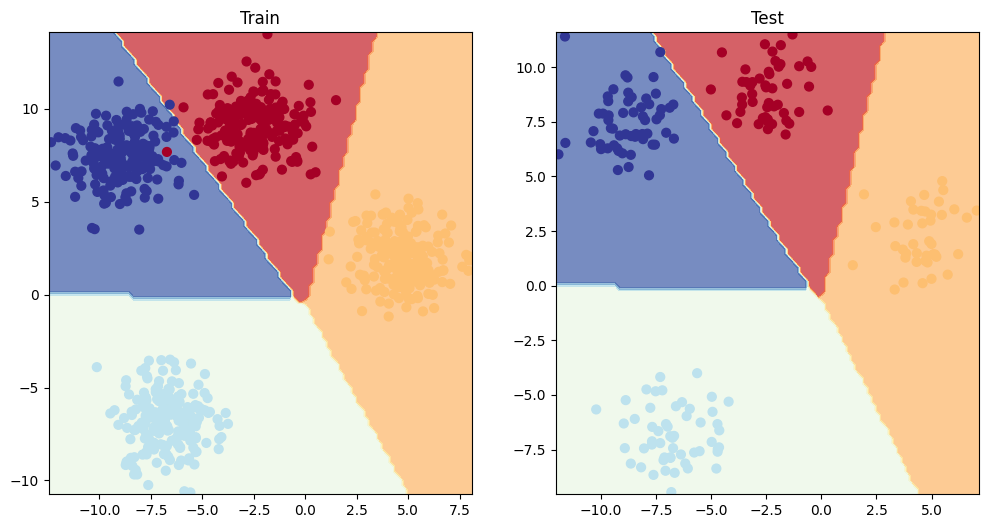

In [82]:
# Simple model doesn't overfit!
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(glorpy_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(glorpy_model, X_blob_test, y_blob_test)

**PyTorch Dummy Path 2024-2025**<br>
<img src="https://images.emojiterra.com/google/noto-emoji/unicode-16.0/color/1024px/1f9ab.png" width=5%>
<img src="https://em-content.zobj.net/source/apple/391/red-heart_2764-fe0f.png" width=5%>
<img src="https://static-00.iconduck.com/assets.00/pytorch-icon-1694x2048-jgwjy3ne.png" width=5%><br>
MIT License, no doubt